<h1 style="color: #A8D0E6;">Used Cars Price Prediction: UK outlook</h1>

<h2 style="color: #A8D0E6;">Importing Libraries</h2>

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

<h2 style="color: #A8D0E6;">Data extraction</h2>

In [3]:
car_brands_list = ['audi', 'bmw', 'ford', 'hyundai', 'mercedes', 'opel', 'skoda', 'toyota', 'volkswagen']

In [4]:
car_data= {}
for brand in car_brands_list:
    car_data[brand] = pd.read_csv(f'{brand}.csv')

In [5]:
car_data["bmw"]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0
...,...,...,...,...,...,...,...,...,...
10776,X3,2016,19000,Automatic,40818,Diesel,150,54.3,2.0
10777,5 Series,2016,14600,Automatic,42947,Diesel,125,60.1,2.0
10778,3 Series,2017,13100,Manual,25468,Petrol,200,42.8,2.0
10779,1 Series,2014,9930,Automatic,45000,Diesel,30,64.2,2.0


<h2 style="color: #A8D0E6;">Datasets overview</h2>

In [6]:
#Checking whether the columns from the 9 dataframes are comparable or not
for brand in car_brands_list:
    print(f"df_{brand} columns:", car_data[brand].columns)

df_audi columns: Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')
df_bmw columns: Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')
df_ford columns: Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')
df_hyundai columns: Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType',
       'tax(£)', 'mpg', 'engineSize'],
      dtype='object')
df_mercedes columns: Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')
df_opel columns: Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')
df_skoda columns: Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg'

##### Variables list:

- `model`: listed car model
- `year`: listed car registration year
- `price`: car's listing price in pounds (£)
- `transmission`: listed car gearbox type (Automatic/Manual)
- `mileage`: listed car's mileage 
- `fuelType`: listed car's fuel Type 
- `tax`: annual car's tax in pounds (£)
- `mpg`: miles per gallon - how far the car can travel for every gallon (or 4.55 litres) of fuel it uses
- `engineSize`: listed car's engine size in litres

- From the previous output one can infer that the data within the different dataframes is similar. In order to uniformize the columns names `car_data["hyundai"] tax(£)` column must change its name description.

In [7]:
#Changing Hyunday's tax column name:
car_data['hyundai'].rename(columns={'tax(£)':'tax'}, inplace = True)

<h3 style="color: #A8D0E6;">Snakecase columns</h3>

In [8]:
#Changing columns' name to snakecase:
for brand in car_brands_list:
    car_data[brand].rename(columns={'fuelType': 'fuel_type', 'engineSize': 'engine_size'}, inplace = True)

<h3 style="color: #A8D0E6;">Creating "brand" column</h3>

In [9]:
#Creating a new column "brand" in each df before concatening
for brand in car_brands_list:
    car_data[brand].insert(0, 'brand', brand.capitalize())

<h3 style="color: #A8D0E6;">Concatenating dataframes</h3>

In [10]:
#Concatenating all the dataframes
cars_df = pd.concat(car_data.values(), ignore_index=True, axis=0)

<h3 style="color: #A8D0E6;">Saving my cars_list dataframe</h3>

In [11]:
cars_df.to_csv("cars_list.csv", index = False)

<h3 style="color: #A8D0E6;">Checking Null Values</h3>

In [12]:
cars_df.isna().sum()

brand           0
model           0
year            0
price           0
transmission    0
mileage         0
fuel_type       0
tax             0
mpg             0
engine_size     0
dtype: int64

<h3 style="color: #A8D0E6;">Checking duplicates</h3>

In [13]:
cars_df.duplicated().sum()

np.int64(1475)

In [14]:
cars_df.shape

(99187, 10)

- Given the context of the dataframe I will keep the duplicated values, it is reasonable to accept listed cars with the same characteristics. 

<h3 style="color: #A8D0E6;">Checking empty spaces</h3>

In [15]:
cars_df.eq('').sum()

brand           0
model           0
year            0
price           0
transmission    0
mileage         0
fuel_type       0
tax             0
mpg             0
engine_size     0
dtype: int64

<h3 style="color: #A8D0E6;">Checking and changing column types</h3>

In [16]:
cars_df.dtypes

brand            object
model            object
year              int64
price             int64
transmission     object
mileage           int64
fuel_type        object
tax               int64
mpg             float64
engine_size     float64
dtype: object

<h3 style="color: #A8D0E6;">From miles to kms</h3>

In [17]:
#Changing both mileage and mpg to kms measure
def miles_to_kms(miles):
    return round((miles * 1.609344), 0)

cars_df["mileage"] = cars_df["mileage"].map(miles_to_kms)
cars_df["mpg"] = cars_df["mpg"].map(miles_to_kms)

In [18]:
#Changing both mileage and mpg type
cars_df["mileage"] = cars_df["mileage"].astype(int)
cars_df["mpg"] = cars_df["mpg"].astype(int)

In [19]:
#Changing mpg colum name (mileage was kept given that is the name in english that suits the most)
cars_df.rename(columns={"mpg":"kmpg"}, inplace=True)
cars_df.rename(columns={"mileage":"mileage(kms)"}, inplace=True)

<h3 style="color: #A8D0E6;">Moving listing price to the right</h3>

In [20]:
column_to_move = cars_df.pop("price")
cars_df["price"] = column_to_move

<h2 style="color: #A8D0E6;">EDA (Exploratory Data Analysis)</h2>

<h3 style="color:  #A8D0E6;">Defining Categorical and Numerical data</h3>

In [21]:
for col in cars_df:
    unique_values = cars_df[col].nunique()
    print(f"Number of unique values in {col} column: {unique_values}")

Number of unique values in brand column: 9
Number of unique values in model column: 195
Number of unique values in year column: 27
Number of unique values in transmission column: 4
Number of unique values in mileage(kms) column: 42214
Number of unique values in fuel_type column: 5
Number of unique values in tax column: 48
Number of unique values in kmpg column: 108
Number of unique values in engine_size column: 40
Number of unique values in price column: 13236


From the variables' context and distinct values we may split them as the following:

**Numerical**:
- `mileage(kms)`;
- `tax`;
- `kmpg`;
- `engine_size`;
- `price`.

**Categorical**:
- `year`;
- `brand`;
- `model`;
- `transmission`;
- `fuel_type`;

In this analysis year will be considered as categorical given that it is solely an attribute of the car and any calculation from it is not meaningful.


In [22]:
#Splitting numerical and categorical variables in two dataframes
df_cat= cars_df[['brand', 'model', 'year', 'transmission', 'fuel_type']]

df_num = cars_df[['mileage(kms)', 'tax', 'kmpg', 'engine_size', 'price']]

<h3 style="color: #A8D0E6;">Categorical vs Categorical</h3>

In [23]:
# Fuel_type by brand
crosstab_fuel_type_brand = pd.crosstab(cars_df["fuel_type"], cars_df["brand"])
crosstab_fuel_type_brand

brand,Audi,Bmw,Ford,Hyundai,Mercedes,Opel,Skoda,Toyota,Volkswagen
fuel_type,,,,,,,,,
Diesel,5577,7027,5762,1608,9187,2823,2069,503,6372
Electric,0,3,2,0,0,1,0,0,0
Hybrid,28,298,22,349,173,2,18,2043,145
Other,0,36,1,1,7,1,9,105,87
Petrol,5063,3417,12178,2902,3752,10805,4171,4087,8553


In [24]:
# Fuel_type by year
crosstab_fuel_type_year= pd.crosstab(cars_df["fuel_type"], cars_df["year"])
crosstab_fuel_type_year

year,1970,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2060
fuel_type,,,,,,,,,,,,,,,,,,,,,
Diesel,1,0,0,1,0,0,1,1,7,10,...,346,1283,2032,4119,8031,8244,3930,10724,1550,0
Electric,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,3,1,0,0,0,0
Hybrid,0,0,0,0,0,0,0,0,0,0,...,5,72,138,222,557,811,369,699,189,0
Other,0,0,0,0,0,0,0,0,0,0,...,0,1,4,14,44,77,15,74,15,0
Petrol,1,2,4,7,6,9,19,30,27,42,...,283,1247,1911,3288,7215,12600,9350,15274,2711,1


In [25]:
cars_df.shape

(99187, 10)

In [26]:
# Year by brand
crosstab_transmission_brand = pd.crosstab(cars_df["brand"], cars_df["transmission"])
crosstab_transmission_brand

transmission,Automatic,Manual,Other,Semi-Auto
brand,,,,
Audi,2708,4369,0,3591
Bmw,3588,2527,0,4666
Ford,1361,15517,0,1087
Hyundai,669,3611,2,578
Mercedes,4825,1444,2,6848
Opel,1184,11980,3,465
Skoda,1104,3754,1,1408
Toyota,2657,3826,1,254
Volkswagen,1960,9417,0,3780


In [27]:
# Year by brand
crosstab_year_brand = pd.crosstab(cars_df["brand"], cars_df["year"])
crosstab_year_brand

year,1970,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2060
brand,,,,,,,,,,,,,,,,,,,,,
Audi,0,0,1,1,0,0,0,2,6,5,...,85,291,447,999,1964,1935,864,3197,716,0
Bmw,0,1,1,1,4,2,3,6,2,12,...,119,357,501,922,1882,1721,848,3485,733,0
Ford,0,1,0,1,0,1,0,3,3,4,...,115,609,805,1367,2331,4888,4014,3194,258,1
Hyundai,0,0,0,0,0,1,0,1,3,0,...,22,120,185,333,716,1178,987,1086,159,0
Mercedes,1,0,1,4,1,3,10,9,7,13,...,57,292,491,991,1971,2381,1467,4553,719,0
Opel,1,0,1,0,0,0,2,5,5,7,...,97,322,541,1070,2502,3125,2086,3187,430,0
Skoda,0,0,0,0,0,0,0,0,0,1,...,17,93,183,285,840,1539,874,2114,276,0
Toyota,0,0,0,1,1,1,1,4,6,7,...,42,204,352,525,997,2019,1015,1286,128,0
Volkswagen,0,0,0,0,0,1,4,1,2,3,...,80,315,580,1153,2647,2947,1509,4669,1046,0


In [28]:
#Filtering out invalid year and not meaningful transmission info
cars_df = cars_df[(cars_df["year"] != 2060) & (cars_df["transmission"] != "Other")]

In [29]:
cars_df.shape

(99177, 10)

##### Chi-square tests

 - From some of the relationships presented before, might be relevant to evaluate whether there are any significant associations. I will perform chi square tests to verify if one can reject the null hypothesis which states that the variables are independent.

In [30]:
crosstab_results = [crosstab_fuel_type_brand, crosstab_fuel_type_year, crosstab_transmission_brand]

In [31]:
for crosstabs in crosstab_results:
    chi2_stats, chi2_pvalue, _, _ = chi2_contingency(crosstabs)
    print(f"p-value is {chi2_pvalue}")

p-value is 0.0
p-value is 0.0
p-value is 0.0


From the low p-values for all the 3 crosstabs we may infer that we have enough evidence to reject that there is independence between:
- `Fuel type` and `brand`;
- `Fuel type` and `year`;
- `Transmission` and `brand`;

##### Cramér's V

In [32]:
for crosstabs in crosstab_results:
    print(association(crosstabs, method="cramer"))    

0.28408757458116457
0.08331637219905492
0.3331728103902129


From https://www.ibm.com/docs/en/cognos-analytics/12.0.0?topic=terms-cramrs-v we get the following result interpretation:

- Cramer's V ≤ 0.2	The result is weak. Although the result is statistically significant, the fields are only weakly associated.
- 0.2 < Cramer's V ≤ 0.6 The result is moderate. The fields are moderately associated.
- Cramer's V > 0.6	The result is strong. The fields are strongly associated.

**Conclusion**: Even though all the 3 relationships are statistically significant, only 2 present a present a moderate association.

<h3 style="color: #A8D0E6;">Categorical vs car price </h3>

In [33]:
#Checking average prices differences between weekdays and weekends bookings
round(cars_df.groupby("brand")["price"].mean().reset_index(), 2)

,brand,price
0,Audi,22896.69
1,Bmw,22733.41
2,Ford,12280.08
3,Hyundai,12749.31
4,Mercedes,24699.95
5,Opel,10404.64
6,Skoda,14275.17
7,Toyota,12522.35
8,Volkswagen,16838.95


In [34]:
#Checking average prices differences between weekdays and weekends bookings
round(cars_df.groupby(["brand", "model"])["price"].mean().reset_index(), 2)

,brand,model,price
0,Audi,A1,14327.75
1,Audi,A2,2490.00
2,Audi,A3,17408.52
3,Audi,A4,20255.45
4,Audi,A5,23577.11
...,...,...,...
190,Volkswagen,Tiguan,21644.75
191,Volkswagen,Tiguan Allspace,28770.30
192,Volkswagen,Touareg,32882.24
193,Volkswagen,Touran,17553.83


In [35]:
#Checking average prices differences between weekdays and weekends bookings
round(cars_df.groupby("fuel_type")["price"].mean().reset_index(), 2)

,fuel_type,price
0,Diesel,19339.63
1,Electric,16645.33
2,Hybrid,19293.91
3,Other,17438.24
4,Petrol,14775.02


In [36]:
#Checking average prices differences between weekdays and weekends bookings
round(cars_df.groupby("transmission")["price"].mean().reset_index(), 2)

,transmission,price
0,Automatic,21558.97
1,Manual,12112.06
2,Semi-Auto,24284.03


<h3 style="color: #A8D0E6;">Categorical vs mileage </h3>

In [37]:
round(cars_df.groupby("brand")["mileage(kms)"].mean().reset_index(), 2)

,brand,mileage(kms)
0,Audi,39955.57
1,Bmw,41033.43
2,Ford,37597.30
3,Hyundai,34574.89
4,Mercedes,35321.20
5,Opel,37825.72
6,Skoda,32381.78
7,Toyota,36786.90
8,Volkswagen,35554.89


<h3 style="color: #A8D0E6;">Categorical vs tax </h3>

In [38]:
round(cars_df.groupby("brand")["tax"].mean().reset_index(), 2)

,brand,tax
0,Audi,126.01
1,Bmw,131.70
2,Ford,113.33
3,Hyundai,121.17
4,Mercedes,129.97
5,Opel,128.76
6,Skoda,117.40
7,Toyota,94.71
8,Volkswagen,112.74


In [39]:
round(cars_df.groupby("fuel_type")["tax"].mean().reset_index(), 2)

,fuel_type,tax
0,Diesel,114.53
1,Electric,22.50
2,Hybrid,72.18
3,Other,103.72
4,Petrol,127.38


<h3 style="color: #A8D0E6;">Continuous vs listing price </h3>

In [40]:
#Checking pearson correlations with car's price
pearson_correlations= df_num.corrwith(cars_df["price"]).sort_values(ascending=False) 
pearson_correlations

price           1.000000
engine_size     0.638161
tax             0.307665
kmpg           -0.296792
mileage(kms)   -0.417951
dtype: float64

In [41]:
#Checking spearman correlations with car's price
spearman_correlations= df_num.corrwith(cars_df["price"], method="spearman").sort_values(ascending=False) 
spearman_correlations

price           1.000000
engine_size     0.586623
tax             0.317698
kmpg           -0.393029
mileage(kms)   -0.511620
dtype: float64

From the previous results we may infer that the strongest correlations arise between car prices and both mileage(kms) - negatively - and engine size - positively. However, while car price/ engine size relationship is more suitable to be described as linear than monotonic, the opposite occurs with car price/mileage(kms) relationship. Let's check all the relationships within scatter plot visualizations.

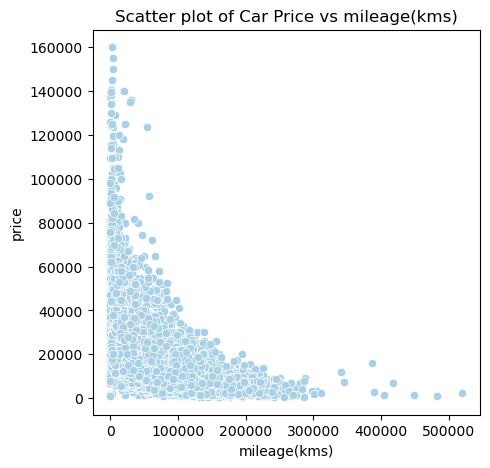

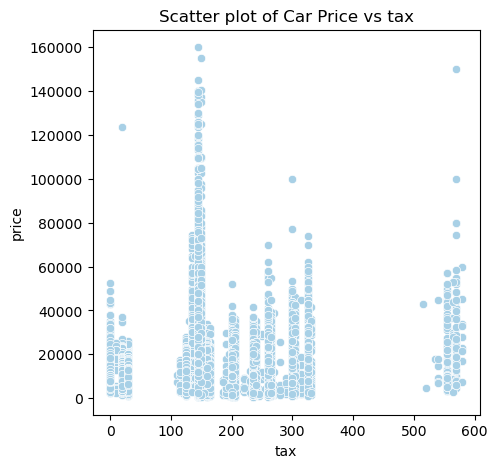

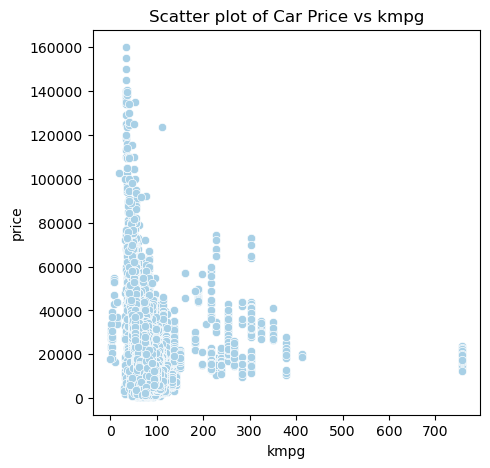

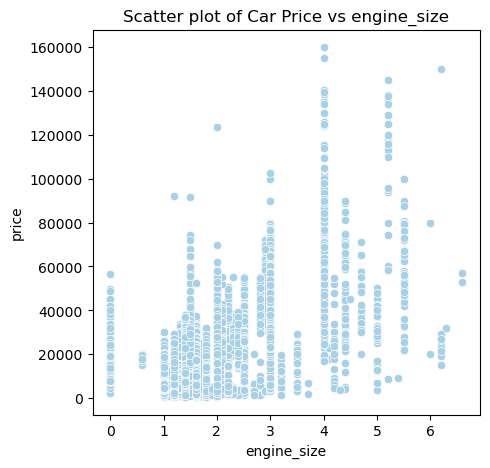

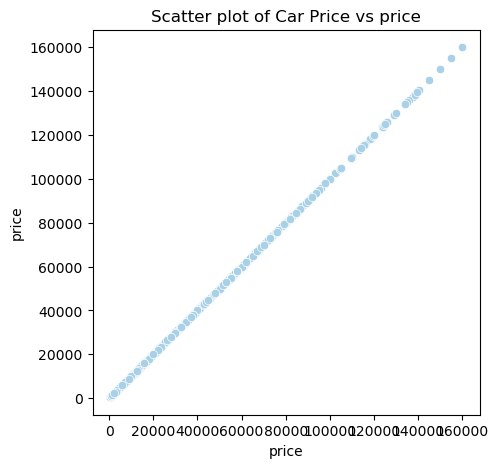

In [42]:
# Plotting scatter plots for each numerical column against 'listing_price' to visualize their relationships
for col in df_num.columns:
    plt.figure(figsize=(5, 5))
    plt.title('Scatter plot of Car Price vs ' + col)
    sns.scatterplot(data=cars_df, x=col, y='price', color="#A8D0E6")
    plt.show()

In [43]:
correlation_matrix = df_num.corr(method="spearman")

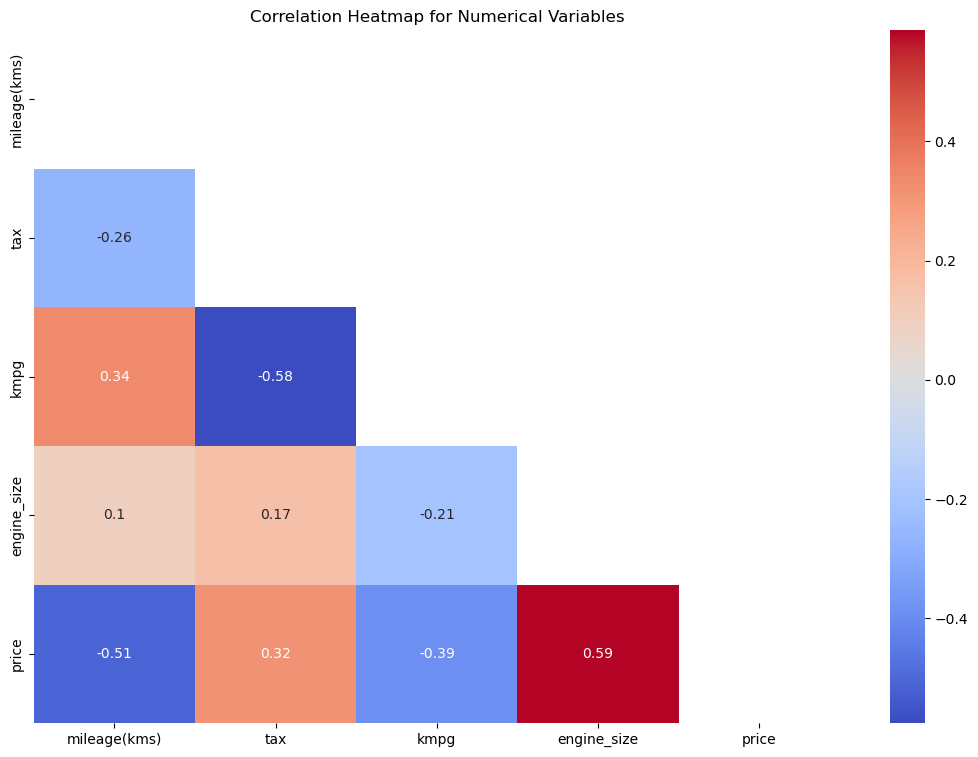

In [44]:
plt.figure(figsize=(13, 9))

# Drawing the heatmap for th
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", mask=mask)

plt.title("Correlation Heatmap for Numerical Variables")
plt.show()

<h4 style="color: #A8D0E6;">Checking Distributions in continuous variables </h4>

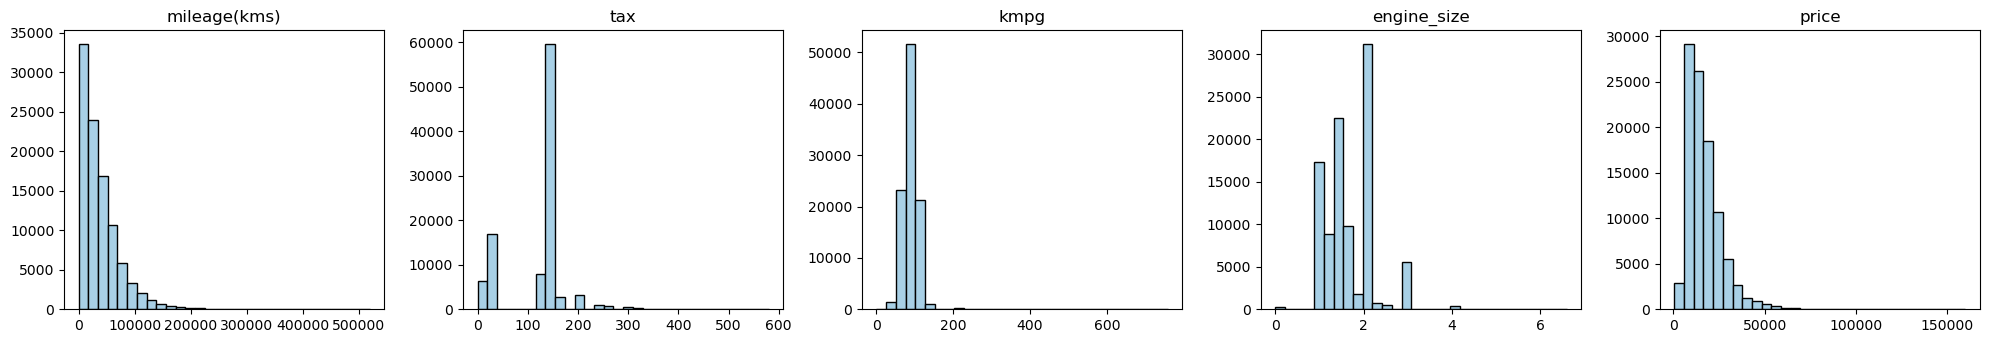

In [45]:
color = '#A8D0E6'

# grid size
nrows, ncols = 5, 5  # adjust for your number of features

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

# Plot each numerical feature
for i, ax in enumerate(axes):
    if i >= len(df_num.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(df_num.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(df_num.columns[i])

plt.tight_layout()
plt.show()

<h4 style="color: #A8D0E6;">Checking Outliers in Continuous variables </h4>

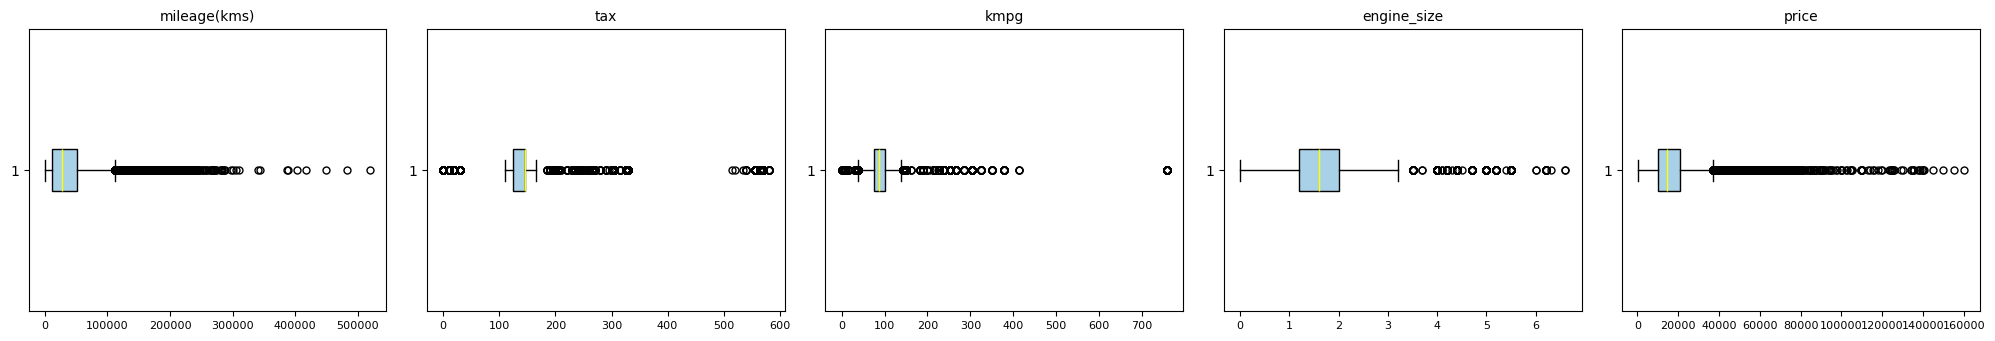

In [46]:
color = '#A8D0E6'

# grid size
nrows, ncols = 5, 5

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(df_num.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(df_num.iloc[:, i].dropna(), vert=False, patch_artist=True,
               boxprops=dict(facecolor=color, color='black'),
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'),
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(df_num.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

<h3 style="color: #A8D0E6;">Statistical summary of box plots</h3>

In [47]:
df_num.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
mileage(kms),99187.0,37109.72,34035.25,2.0,11949.5,28099.0,52044.5,519818.0
tax,99187.0,120.30,63.15,0.0,125.0,145.0,145.0,580.0
kmpg,99187.0,88.82,26.00,0.0,76.0,87.0,101.0,758.0
engine_size,99187.0,1.66,0.56,0.0,1.2,1.6,2.0,6.6
price,99187.0,16805.35,9866.77,450.0,9999.0,14495.0,20870.0,159999.0


**Quick insights:**
- The maximum mileage presented in a listed car is above **500 000 kms**;
- The most expensive car costs up to **160 000 £** while the cheapest is around **16 800 £**.

<h3 style="color: #A8D0E6;">Hypothesis testing</h3>

#### Hypotheses **#1**
- **Null Hypothesis (H₀)**: There is no difference in the listed price mean between different fuel type cars.

- **Alternative Hypothesis (H₁)**: At least one group mean is different.

In [48]:
# Filtering by fuel type 
df_petrol = cars_df[(cars_df["fuel_type"] == "Petrol")]["price"]
df_diesel= cars_df[(cars_df["fuel_type"] == "Diesel")]["price"]
df_hybrid = cars_df[(cars_df["fuel_type"] == "Hybrid")]["price"]
df_other = cars_df[(cars_df["fuel_type"] == "Other")]["price"]
df_electric = cars_df[(cars_df["fuel_type"] == "Electric")]["price"]

In [49]:
# Perform One-Way ANOVA
f_stat, p_value = st.f_oneway(df_petrol, df_diesel, df_hybrid, df_other, df_electric)
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()

# Significance level
alpha = 0.05

# Decision-Making
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: Fuel type has no significant impact on cars' listing prices.")
else:
    print("Reject the Null Hypothesis: There is a significant difference in prices based on fuel type.")

F-Statistic: 1377.96
P-Value: 0.0000

Reject the Null Hypothesis: There is a significant difference in prices based on fuel type.


#### Hypotheses **#2**
- **Null Hypothesis (H₀)**: The mean listed price for automatic cars is equal to the mean listed price for semi-automatic cars.

- **Alternative Hypothesis (H₁)**: The mean listed price for automatic cars is not equal to the mean listed price for semi-automatic cars.

In [50]:
# Listing prices for the two defined samples 
automatic_price = cars_df[cars_df["transmission"] == "Automatic"]["price"]
semi_automatic_price = cars_df[cars_df["transmission"] == "Semi-Auto"]["price"]

# Perform two-sample t-test for independent samples
t_stat, p_value = st.ttest_ind(automatic_price, semi_automatic_price, equal_var=False)
print(f"Test Statistic (t): {t_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()

# Significance level
alpha = 0.05

# Decision-Making
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: The mean listed price for automatic and semi-automatic cars is not significantly different.")
else:
    print("Reject the Null Hypothesis: There is sufficient evidence to conclude that the mean listed price is different for automatic and semi-automatic cars.")

Test Statistic (t): -25.13
P-Value: 0.0000

Reject the Null Hypothesis: There is sufficient evidence to conclude that the mean listed price is different for automatic and semi-automatic cars.


<h2 style="color: #A8D0E6;">Machine Learning </h2>

 **In this section I will test 2 different random forest models.**
 - In the first one I will directly apply one hot enconding to brand, transmission and fuel type, as well as label encoding to car model variable given the 195 different values;
 - In the second one I will try to reduce the different values from fuel types and models. Will group Hybrid, Other and Electric in ALternative as well as group in "Other" thos least popular models that have less than 300 listed cars.

<h3 style="color: #A8D0E6;">Model 1 </h3>

In [51]:
used_cars_ML = cars_df.copy()

<h3 style="color: #A8D0E6;">One-hot encoding transmission and fuel type - Option 1 </h3>

In [52]:
used_cars_ML.transmission.unique()

array(['Manual', 'Automatic', 'Semi-Auto'], dtype=object)

In [53]:
#Creating dummy variables for transmission types
transmission_dummies = pd.get_dummies(used_cars_ML["transmission"], prefix="transmission")

In [54]:
#Creating dummy variables for fuel types
fuel_type_dummies = pd.get_dummies(used_cars_ML["fuel_type"], prefix="fuel_type")

In [55]:
#Creating dummy variables for brands
brand_dummies = pd.get_dummies(used_cars_ML["brand"], prefix="brand")

In [56]:
used_cars_ML = pd.concat([used_cars_ML, transmission_dummies, fuel_type_dummies, brand_dummies], axis=1)
used_cars_ML = used_cars_ML.drop(columns=["transmission", "fuel_type", "brand"])
used_cars_ML = used_cars_ML * 1

In [57]:
used_cars_ML.head()

,model,year,mileage(kms),tax,kmpg,engine_size,price,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,...,fuel_type_Petrol,brand_Audi,brand_Bmw,brand_Ford,brand_Hyundai,brand_Mercedes,brand_Opel,brand_Skoda,brand_Toyota,brand_Volkswagen
0,A1,2017,25323,150,89,1.4,12500,0,1,0,...,1,1,0,0,0,0,0,0,0,0
1,A6,2016,58263,20,103,2.0,16500,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,A1,2016,48193,30,89,1.4,11000,0,1,0,...,1,1,0,0,0,0,0,0,0,0
3,A4,2017,41766,145,108,2.0,16800,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,A3,2019,3215,145,80,1.0,17300,0,1,0,...,1,1,0,0,0,0,0,0,0,0


<h3 style="color: #A8D0E6;">Label encoding model </h3>

In [58]:
from sklearn.preprocessing import LabelEncoder

In [59]:
encoder = LabelEncoder()

# Encoding model column
used_cars_ML['model_encoded'] = encoder.fit_transform(used_cars_ML['model'])


In [60]:
#Dropping model column
used_cars_ML = used_cars_ML.drop(columns= ["model"])

<h3 style="color: #A8D0E6;">Target - Option 1 </h3>

In [61]:
target = used_cars_ML.pop("price")
used_cars_ML["price"] = column_to_move

<h3 style="color: #A8D0E6;">X-y split #1</h3>

In [62]:
X = used_cars_ML.drop("price", axis=1)
y = used_cars_ML["price"]

<h3 style="color: #A8D0E6;">Train-Test split #1</h3>

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<h3 style="color: #A8D0E6;">Model: Random Forest #1 </h3>

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [66]:
#Validation
forest_predictions = forest_model.predict(X_test)

In [67]:
#Metrics
r2_forest_model = r2_score(y_test, forest_predictions)
MSE_forest_model  = mean_squared_error(y_test, forest_predictions)
RMSE_forest_model  = MSE_forest_model ** 0.5
MAE_forest_model  = mean_absolute_error(y_test, forest_predictions)

In [68]:
#Printing the results
print("R2 = ", round(r2_forest_model, 4))
print("RMSE = ", round(RMSE_forest_model, 2))
print("MSE =  ", round(MSE_forest_model, 2)) 
print("MAE = ", round(MAE_forest_model, 2))

R2 =  0.9569
RMSE =  2046.56
MSE =   4188390.95
MAE =  1161.82


<h3 style="color: #A8D0E6;">Checking feature importance for Random forest </h3>

In [69]:
feature_names = list(X_train.columns)
forest_importances = forest_model.feature_importances_
indices = np.argsort(forest_importances)[::-1] # sorts indices of importances in descending order

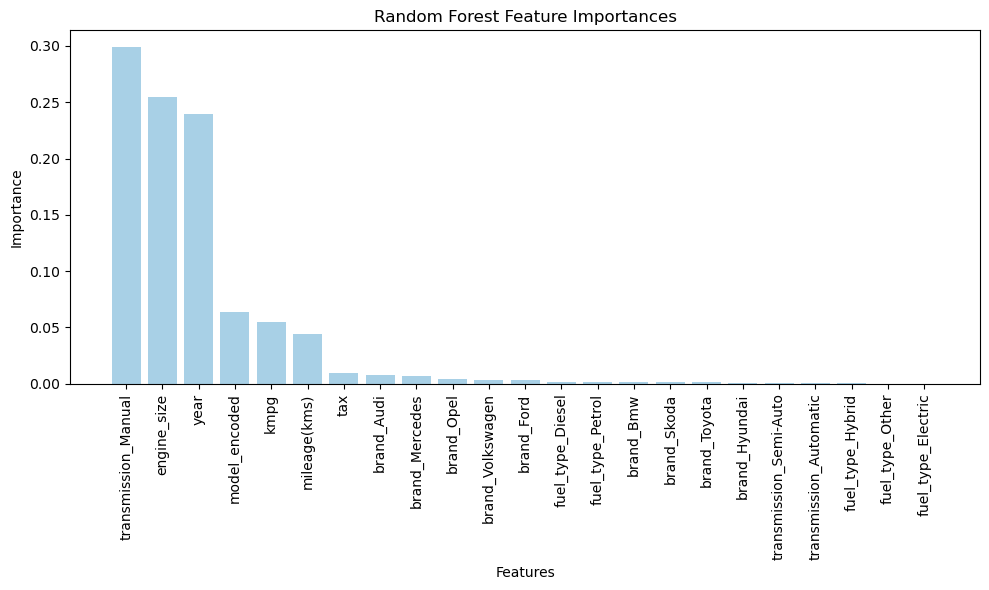

In [70]:
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(X.shape[1]), forest_importances[indices], align="center", color="#A8D0E6")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

<h3 style="color: #A8D0E6;">Model 2 </h3>

In [71]:
used_cars_ML_2 = cars_df.copy()

<h3 style="color: #A8D0E6;">One-hot encoding transmission and fuel type - Option 2 </h3>

In [72]:
#Creating dummy variables for transmission types
transmission_dummies_2 = pd.get_dummies(used_cars_ML_2["transmission"], prefix="transmission")

In [73]:
#Decreasing the amount of fuel_types
used_cars_ML_2["fuel_type"] = used_cars_ML_2["fuel_type"].replace({"Hybrid": "Alternative", "Other": "Alternative", "Electric": "Alternative"})

In [74]:
#Creating dummy variables for fuel types
fuel_type_dummies_2 = pd.get_dummies(used_cars_ML_2["fuel_type"], prefix="fuel_type")

In [75]:
#Creating dummy variables for brands
brand_dummies_2 = pd.get_dummies(used_cars_ML_2["brand"], prefix="brand")

In [76]:
used_cars_ML_2= pd.concat([used_cars_ML_2, transmission_dummies_2, fuel_type_dummies_2, brand_dummies_2], axis=1)
used_cars_ML_2 = used_cars_ML_2.drop(columns=["transmission", "fuel_type", "brand"])
used_cars_ML_2 = used_cars_ML_2 * 1

<h3 style="color: #A8D0E6;">Label encoding model - Option 2 </h3>

In [77]:
#Getting the count for models
model_counts= used_cars_ML_2.model.value_counts()

In [78]:
#Getting the most popular models to reduce unique values 
popular_models = model_counts[model_counts > 299]

In [79]:
#Replacing the least popular with Other
used_cars_ML_2["model"] = used_cars_ML_2["model"].apply(lambda x: x if x in popular_models else "Other")

In [80]:
encoder = LabelEncoder()

# Encoding model column
used_cars_ML_2['model_encoded'] = encoder.fit_transform(used_cars_ML_2['model'])


In [81]:
#Dropping model column
used_cars_ML_2 = used_cars_ML_2.drop(columns= ["model"])

<h3 style="color: #A8D0E6;">Target - Option 2 </h3>

In [82]:
target = used_cars_ML_2.pop("price")
used_cars_ML_2["price"] = column_to_move

<h3 style="color: #A8D0E6;">X-y split #2</h3>

In [83]:
X_2 = used_cars_ML_2.drop("price", axis=1)
y_2 = used_cars_ML_2["price"]

<h3 style="color: #A8D0E6;">Train-Test split #2</h3>

In [84]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

<h3 style="color: #A8D0E6;">Model: Random Forest #2 </h3>

In [85]:
forest_model = RandomForestRegressor()
forest_model.fit(X_train_2, y_train_2)

RandomForestRegressor()

In [86]:
#Validation
forest_predictions = forest_model.predict(X_test_2)

In [88]:
#Metrics
r2_forest_model_2 = r2_score(y_test_2, forest_predictions)
MSE_forest_model_2  = mean_squared_error(y_test_2, forest_predictions)
RMSE_forest_model_2  = MSE_forest_model_2 ** 0.5
MAE_forest_model_2  = mean_absolute_error(y_test_2, forest_predictions)

In [89]:
#Printing the results
print("R2 = ", round(r2_forest_model_2, 4))
print("RMSE = ", round(RMSE_forest_model_2, 2))
print("MSE =  ", round(MSE_forest_model_2, 2)) 
print("MAE = ", round(MAE_forest_model_2, 2))

R2 =  0.9558
RMSE =  2073.08
MSE =   4297645.53
MAE =  1178.25


<h3 style="color: #A8D0E6;">Checking feature importance for Random forest #2 </h3>

In [90]:
feature_names = list(X_train_2.columns)
forest_importances = forest_model.feature_importances_
indices = np.argsort(forest_importances)[::-1] # sorts indices of importances in descending order

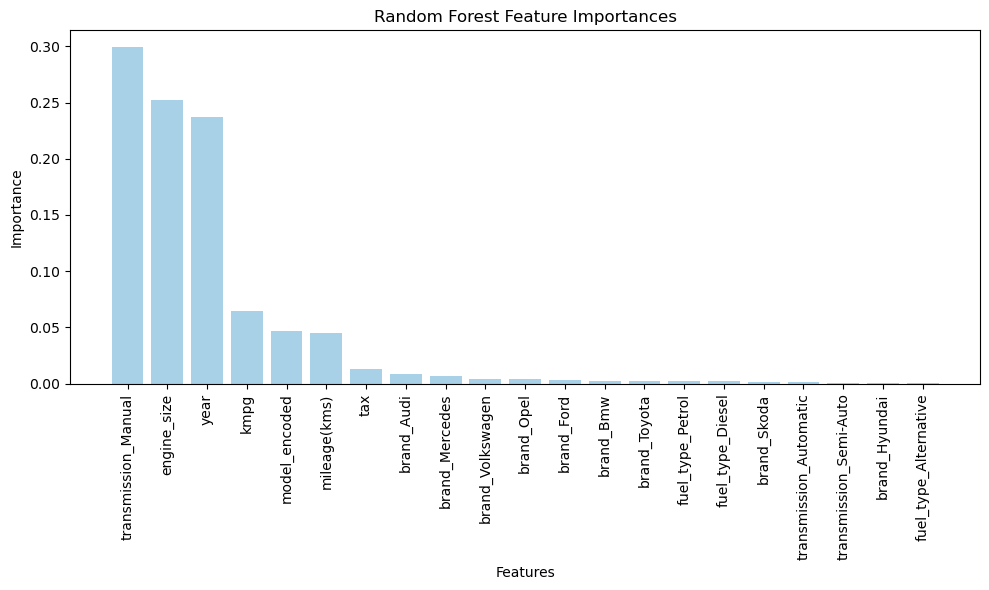

In [91]:
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(X_2.shape[1]), forest_importances[indices], align="center", color="#A8D0E6")
plt.xticks(range(X_2.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

**The metrics did not improve with the second model's modifications. Given this I will keep the first one for later usage.**